In [77]:
import frame
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh

In [78]:
def create_node_dual_graph(nodes, elements):
    G = nx.Graph()
    
    # Add nodes to the graph
    for node in nodes:
        G.add_node(node.id, pos=(node.x, node.y))
    
    # Add edges based on element connectivity
    for element in elements:
        if element.id <= 26:
            G.add_edge(element.nodes_ids[0], element.nodes_ids[1], weight=0.3)
        else:
            G.add_edge(element.nodes_ids[0], element.nodes_ids[1], weight=0.3)
    
    return G

def plot_graph(G):
    pos = nx.get_node_attributes(G, 'pos')
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')

In [79]:
def color_graph(G):
    # Use the greedy coloring algorithm to color the graph
    coloring = nx.coloring.greedy_color(G, strategy="largest_first")
    return coloring

def plot_colored_graph(G, coloring):
    pos = nx.get_node_attributes(G, 'pos')
    colors = plt.cm.rainbow(np.linspace(0, 1, max(coloring.values()) + 1))
    
    for node, color in coloring.items():
        nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color=[colors[color]], node_size=200)
    
    nx.draw_networkx_edges(G, pos, edge_color='gray')
    nx.draw_networkx_labels(G, pos)
    plt.show()

In [80]:
def spectral_partitioning(G):
    # Compute the Laplacian matrix of the graph
    L = nx.laplacian_matrix(G, weight="weight").astype(float)
    
    # Compute the first k eigenvectors of the Laplacian matrix
    _, eigvecs = eigsh(L, k=2, which='SM')
    
    # Use the eigenvectors to partition the graph
    # Here we use k-means clustering on the eigenvectors
    return (np.sign(eigvecs).astype(int)[:,1] + 1)//2

def naive_partitioning(G, num_ranks):
    colors = plt.cm.rainbow(np.linspace(0, 1, num_ranks + 1))

    partitioning = []
    nnodes = G.number_of_nodes()
    nodes_per_rank = int(nnodes/num_ranks)
    for rank in range(num_ranks):
        if (rank != num_ranks - 1):
            nodes = list(range(rank*nodes_per_rank + 1, (rank + 1) * nodes_per_rank + 1))
        else:
            nodes = list(range(rank*nodes_per_rank + 1, nnodes + 1))

        partitioning.append((nodes, rank))

    return partitioning

In [81]:
def plot_partitioned_graph(G, partition_labels, ax):
    pos = nx.get_node_attributes(G, 'pos')
    colors = plt.cm.rainbow(np.linspace(0, 1, len(np.unique(partition_labels))))
    nodal_list = np.array(list(G.nodes))
    
    nx.draw_networkx_nodes(G, pos, nodelist=nodal_list[partition_labels.astype(bool)], node_color=[colors[0]], node_size=200, ax=ax)
    nx.draw_networkx_nodes(G, pos, nodelist=nodal_list[~partition_labels.astype(bool)], node_color=[colors[1]], node_size=200, ax=ax)
    nx.draw_networkx_edges(G, pos, edge_color='gray', ax=ax)
    nx.draw_networkx_labels(G, pos, ax=ax)
    

def plot_naive_partitioned_graph(G, partition, ax):
    pos = nx.get_node_attributes(G, 'pos')
    colors = plt.cm.rainbow(np.linspace(0, 1, len(partition) + 1))
    
    for node, color in partition:
        nx.draw_networkx_nodes(G, pos, nodelist=node, node_color=[colors[color]], node_size=200, ax=ax)
    
    nx.draw_networkx_edges(G, pos, edge_color='gray', ax=ax)
    nx.draw_networkx_labels(G, pos, ax=ax)

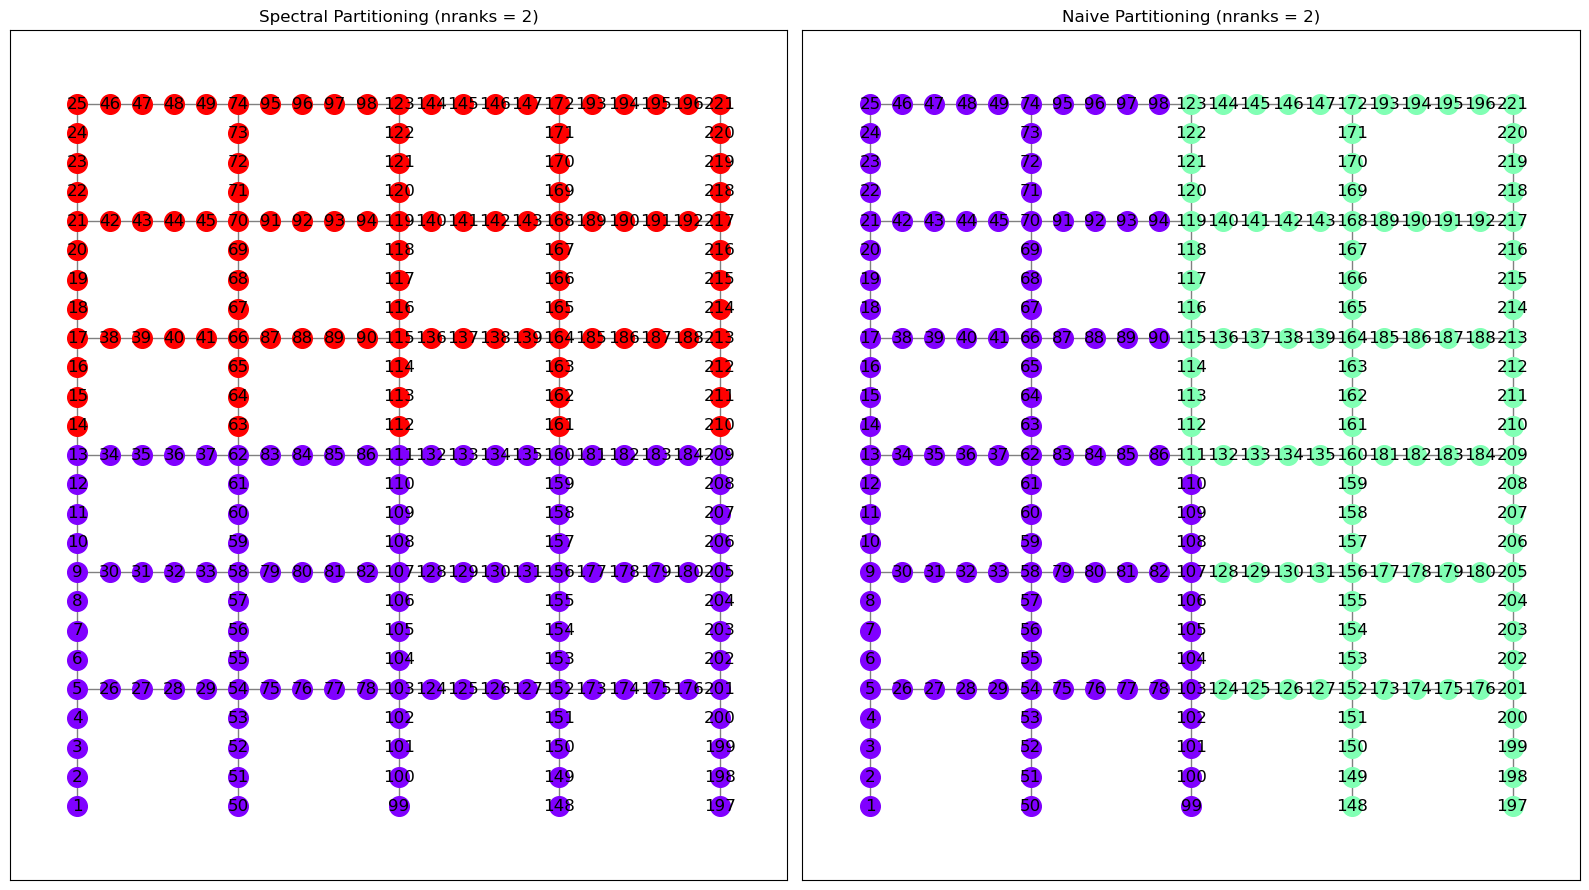

In [85]:
nranks = 2
n_bays = 4
n_floors = 6
a_frame = frame.frame(num_bays = n_bays, num_floors = n_floors, 
                bay_length = 6, floor_height = 4, 
                elements_per_bay = 5, elements_per_floor = 4)
# a_frame.plot_mesh() 
dual_graph = create_node_dual_graph(a_frame.nodes, a_frame.elements)

partitioning = naive_partitioning(dual_graph, nranks)
partition_labels = spectral_partitioning(dual_graph)
# for partition in partitioning:
#     print(f"rank {partition[1]} has the following {len(partition[0])} nodes {partition[0]}")

fig, axs = plt.subplots(1,2)
plot_partitioned_graph(dual_graph, partition_labels, axs[0])
plot_naive_partitioned_graph(dual_graph, partitioning, axs[1])
axs[0].set_title("Spectral Partitioning (nranks = 2)")
axs[1].set_title(f"Naive Partitioning (nranks = {nranks})")
fig.set_size_inches(n_bays*4, n_floors*1.5)
plt.tight_layout()
fig.savefig(f"{n_floors}floors_{n_bays}bays_naive_spectral.png", dpi=300)

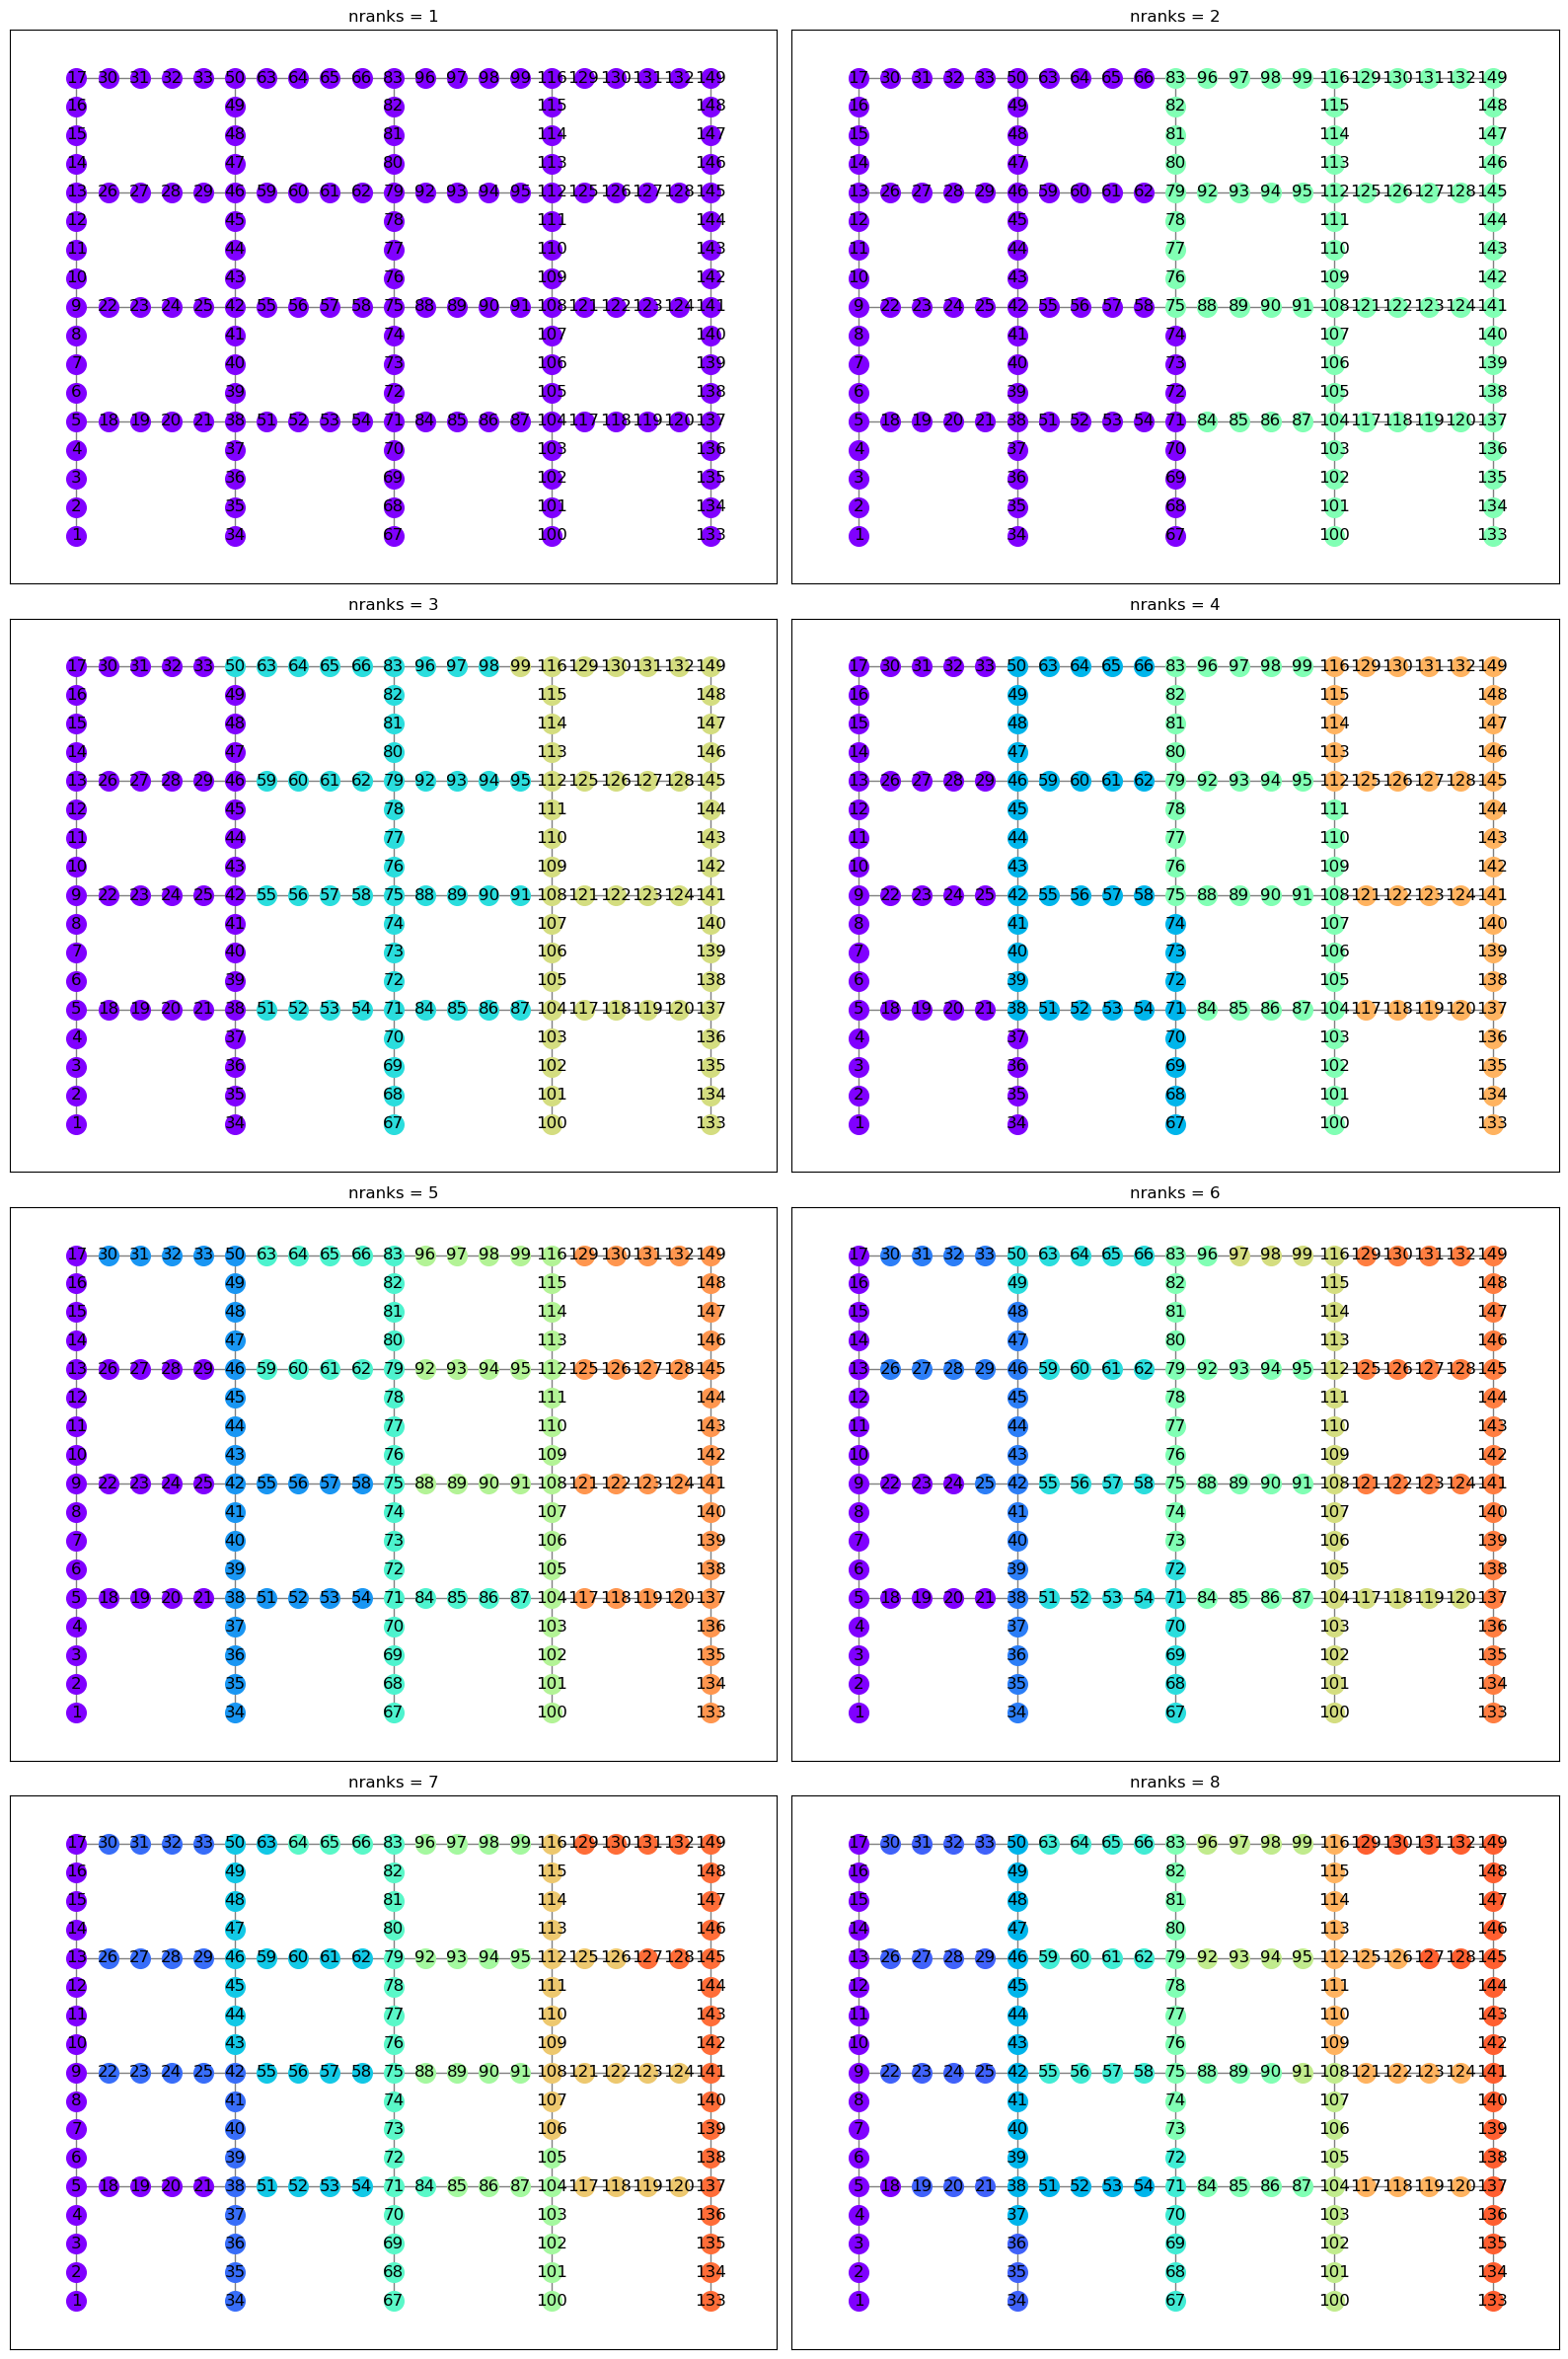

In [83]:

max_nranks = 8
n_bays = 4
n_floors = 4
a_frame = frame.frame(num_bays = n_bays, num_floors = n_floors, 
                bay_length = 6, floor_height = 4, 
                elements_per_bay = 5, elements_per_floor = 4)
# a_frame.plot_mesh() 
dual_graph = create_node_dual_graph(a_frame.nodes, a_frame.elements)
fig, axs = plt.subplots(max_nranks//2,2)

i = 0
for ax in axs.flatten():
    i += 1
    partitioning = naive_partitioning(dual_graph, i)
    plot_naive_partitioned_graph(dual_graph, partitioning, ax)
    ax.set_title(f"nranks = {i}")


fig.set_size_inches(n_bays*4, n_floors*0.75*max_nranks)
plt.tight_layout()
plt.savefig(f"{n_floors}floors_{n_bays}bays_{max_nranks}ranks_naive.png")